# OLS on Basic Variable Set

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
from reed import *
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time
import statsmodels.api as sm


# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

#### Select modeling parameters

In [4]:
outcome = 'y_Dwsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-basic.pkl"
bootstrap_cache = "data/bootstrap-basic.pkl"
data_file = "basic_variables.csv"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [5]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [6]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3659, 21)
Treated data dimensions: (1295, 21)


### Compute unconditional/unadjusted estimate of treatment effect

In [7]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [8]:
from sklearn.linear_model import LinearRegression
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

In [9]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=3,
    outercv=5,
    load_from_cache=False)

Fitting OLS ...Done
Caching results to data/cross-val-basic.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
OLS,-14.94,27.56,0.19,0.05,0.14,0.05,"-700,735.10","108,642.43","-962,232.05","214,579.18"


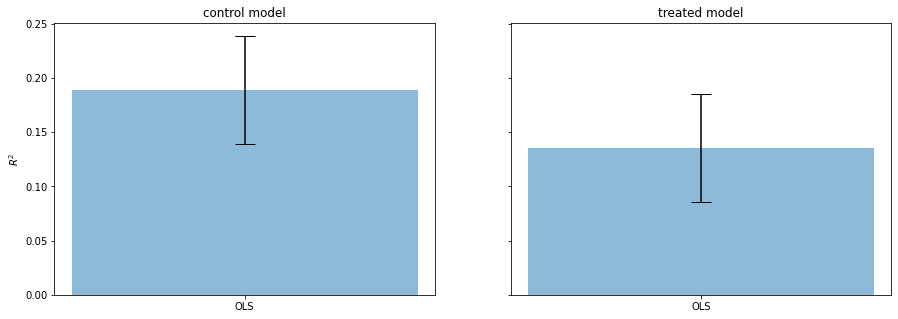

In [8]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models

In [9]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

OLS


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
"ahgage_(54, 120]",529.663333,23.969218,-20.357861,43.172372,-539.842264,43.880916,-519.484403,12.467516
"ahgage_(44, 54]",511.140737,14.986191,32.881497,19.967754,-494.699989,21.754914,-527.581486,13.238247
aesdtl_3.0,183.313851,10.952190,-87.018011,42.426085,139.804845,31.953525,226.822856,10.902272
ahgsex_2.0,180.739475,47.923537,361.478950,95.847075,162.718217,73.690803,-198.760733,55.889543
"interact_ahgsex_2.0_ahgage_(54, 120]",150.779378,20.013013,-56.047737,41.762699,122.755510,38.335830,178.803247,14.264189
"interact_ahgsex_2.0_ahgage_(44, 54]",142.288077,5.804131,-79.326836,18.093367,102.624659,12.526419,181.951496,8.611020
"ahgage_(34, 44]",107.935580,20.586581,2.262314,13.369662,-106.804423,20.109278,-109.066737,23.078248
aedhigh1_5.0,103.361242,48.273424,197.830223,106.593364,170.621567,91.007890,-27.208656,30.162568
interact_ahgsex_2.0_aedhigh1_9.0,102.277355,22.334978,-189.203286,63.565133,-166.555316,32.070172,22.647970,54.384796


### What are the major confounders

  - We want to identify variables that strongly effect both treatment and outcome
   
For each variable Z, in the covariate set lets compute $E[Z|T=1] - E[Z|T=0]$

In [10]:
Xt = np.hstack((t.reshape(-1,1),X))
model = LinearRegression()
model.fit(Xt,y)
beta = model.coef_[1:]

confound = pd.DataFrame({'response_coef':beta, 'treatment_inf':X1.mean(axis=0) - X0.mean(axis=0)},index=features)
confound['confound'] = np.abs(confound['response_coef'])*np.abs(confound['treatment_inf'])
confound.sort_values(by='confound',ascending=False)

,response_coef,treatment_inf,confound
"ahgage_(54, 120]",-502.562913,-0.591578,297.305260
"ahgage_(44, 54]",-511.807500,-0.122214,62.550247
aesdtl_3.0,214.603922,-0.276422,59.321186
"interact_ahgsex_2.0_ahgage_(54, 120]",139.495045,-0.408466,56.979029
"ahgage_(34, 44]",-103.761223,0.276012,28.639297
aedhigh1_9.0,-62.226541,-0.263276,16.382773
ahgsex_2.0,-88.681116,0.136779,12.129733
aesdtl_2.0,73.959942,0.118119,8.736107
"interact_ahgsex_2.0_ahgage_(44, 54]",145.716064,-0.048613,7.083682
interact_ahgsex_2.0_aedhigh1_5.0,-49.242464,0.094926,4.674381


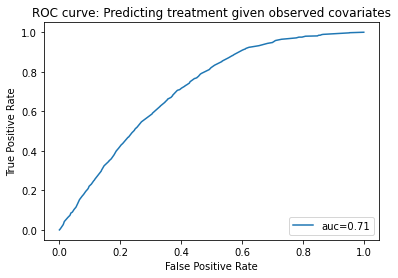

In [11]:
p_model = LogisticRegression()
p_model.fit(X,t)
p_model.coef_
p = p_model.predict_proba(X)[:,1]
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(t,p)
fpr, tpr, _ = roc_curve(t,p)
plt.plot(fpr, tpr,label=f'auc={auc:.2f}')
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: Predicting treatment given observed covariates");

In [12]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    construct_models,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=3,
    load_from_cache=False,
    samples=1000
)

Fitting OLS ...Done
Total time:3.53975248336792 seconds
Caching results to: data/bootstrap-basic.pkl


####  Average treatment effect uncertainty via Bootstrapping

In [13]:
from direct_regression import estimate_causal_effect
for model_name, (results0, results1) in bootstrap_results.items():
    models0 = [r['estimator'] for r in results0]
    models1 = [r['estimator'] for r in results1]
    ate = estimate_causal_effect(X,models0, models1)
    print(f'{model_name}, {ate.mean():.2f} ± {ate.std():.2f}')

OLS, -12.23 ± 34.17


## Statsmodels

Statsmodels provides a useful comparison, in that it is an independent implementation of OLS and provides theory based confidence intervals and p-values.

### Control Model

In [17]:
x0 = sm.add_constant(X0)
x0 = pd.DataFrame(x0, columns=['intercept']+features)
model0 = sm.OLS(y0,x0)
sm_result = model0.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     44.32
Date:                Fri, 08 Oct 2021   Prob (F-statistic):          2.64e-162
Time:                        09:56:52   Log-Likelihood:                -29782.
No. Observations:                3659   AIC:                         5.961e+04
Df Residuals:                    3637   BIC:                         5.975e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                              123.3926     14.006      8.810      0.000      95.933     150.853
ahgage_(34, 44]                       -109.2243     28.009     -3.900      0.000    -164.140     -54.308
ahgage_(44, 54]                       -527.6135     27.159    -19.427      0.000    -580.863    -474.364
ahgage_(54, 120]                      -519.4854     28.639    -18.139      0.000    -575.635    -463.336
ahgsex_2.0                            -199.2181     57.733     -3.451      0.001    -312.411     -86.025
aedhigh1_3.0                           -52.7436     29.907     -1.764      0.078    -111.379       5.892
aedhigh1_4.0                           -66.6812     27.699     -2.407      0.016    -120.988     -12.374
aedhigh1_5.0                           -27.5796     30.325     -0.909      0.363     -87.034      31.875
aedhigh1_8.0                           -72.6881     31.084     -2.338      0.019    -133.633     -11.743
aedhigh1_9.0                          -108.9205     37.631     -2.894      0.004    -182.701     -35.140
aesdtl_2.0                              65.9919     29.516      2.236      0.025       8.123     123.861
aesdtl_3.0                             226.7638     26.195      8.657      0.000     175.405     278.123
interact_ahgsex_2.0_ahgage_(34, 44]     31.5044     31.163      1.011      0.312     -29.594      92.603
interact_ahgsex_2.0_ahgage_(44, 54]    181.8225     29.486      6.166      0.000     124.012     239.633
interact_ahgsex_2.0_ahgage_(54, 120]   178.8144     30.660      5.832      0.000     118.702     238.927
interact_ahgsex_2.0_aedhigh1_3.0        36.7533     31.661      1.161      0.246     -25.322      98.829
interact_ahgsex_2.0_aedhigh1_4.0        33.9436     28.925      1.174      0.241     -22.767      90.654
interact_ahgsex_2.0_aedhigh1_5.0       -17.2781     27.309     -0.633      0.527     -70.820      36.264
interact_ahgsex_2.0_aedhigh1_8.0        14.9351     34.242      0.436      0.663     -52.201      82.071
interact_ahgsex_2.0_aedhigh1_9.0        23.1758     46.689      0.496      0.620     -68.364     114.716
interact_ahgsex_2.0_aesdtl_2.0          27.6567     33.146      0.834      0.404     -37.329      92.642
interact_ahgsex_2.0_aesdtl_3.0         -40.7440     31.764     -1.283      0.200    -103.021      21.533
==============================================================================
Omnibus:                     2705.022   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           225392.517
Skew:                           2.827   Prob(JB):                         0.00
Kurtosis:                      41.032   Cond. No.                         13.8
===============================================================

### Treated Model

In [20]:
x1 = sm.add_constant(X1)
x1 = pd.DataFrame(x1, columns=['intercept']+features)
model1 = sm.OLS(y1,x1)
sm_result = model1.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     13.03
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           4.95e-41
Time:                        09:58:11   Log-Likelihood:                -10730.
No. Observations:                1295   AIC:                         2.150e+04
Df Residuals:                    1273   BIC:                         2.162e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                              109.4973     36.584      2.993      0.003      37.725     181.270
ahgage_(34, 44]                       -105.4615     45.598     -2.313      0.021    -194.918     -16.005
ahgage_(44, 54]                       -494.3064     50.527     -9.783      0.000    -593.432    -395.180
ahgage_(54, 120]                      -538.1974     87.133     -6.177      0.000    -709.138    -367.257
ahgsex_2.0                             164.4545    102.949      1.597      0.110     -37.514     366.423
aedhigh1_3.0                           138.4484     60.495      2.289      0.022      19.768     257.129
aedhigh1_4.0                            50.7008     55.936      0.906      0.365     -59.037     160.438
aedhigh1_5.0                           172.4740     63.650      2.710      0.007      47.604     297.344
aedhigh1_8.0                            88.7742     64.294      1.381      0.168     -37.359     214.907
aedhigh1_9.0                            65.4833     85.534      0.766      0.444    -102.320     233.287
aesdtl_2.0                              99.2355     68.671      1.445      0.149     -35.485     233.956
aesdtl_3.0                             139.9625     63.211      2.214      0.027      15.953     263.972
interact_ahgsex_2.0_ahgage_(34, 44]    -13.3921     47.163     -0.284      0.776    -105.919      79.135
interact_ahgsex_2.0_ahgage_(44, 54]    101.8703     52.381      1.945      0.052      -0.893     204.633
interact_ahgsex_2.0_ahgage_(54, 120]   121.2275     89.524      1.354      0.176     -54.403     296.858
interact_ahgsex_2.0_aedhigh1_3.0      -124.2003     57.823     -2.148      0.032    -237.640     -10.761
interact_ahgsex_2.0_aedhigh1_4.0       -74.4408     53.393     -1.394      0.163    -179.188      30.306
interact_ahgsex_2.0_aedhigh1_5.0      -149.9237     50.178     -2.988      0.003    -248.364     -51.484
interact_ahgsex_2.0_aedhigh1_8.0      -109.0298     64.706     -1.685      0.092    -235.971      17.912
interact_ahgsex_2.0_aedhigh1_9.0      -167.2916     94.247     -1.775      0.076    -352.188      17.604
interact_ahgsex_2.0_aesdtl_2.0           4.3130     70.204      0.061      0.951    -133.416     142.042
interact_ahgsex_2.0_aesdtl_3.0          48.1986     67.902      0.710      0.478     -85.014     181.411
==============================================================================
Omnibus:                      430.882   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9998.151
Skew:                           0.989   Prob(JB):                         0.00
Kurtosis:                      16.468   Cond. No.                         13.6
===============================================================

### Fully coupled model
Fit a single model for both treatment and control surfaces with a treatment indicator. 

```{note}
This assumes there is no treatment effect heterogeneity
```

In [24]:
x = np.hstack((t.reshape(-1,1),X))
x = sm.add_constant(x)
x = pd.DataFrame(x, columns=['intercept','treatment']+features)
model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     56.24
Date:                Fri, 08 Oct 2021   Prob (F-statistic):          4.69e-220
Time:                        10:03:25   Log-Likelihood:                -40547.
No. Observations:                4954   AIC:                         8.114e+04
Df Residuals:                    4931   BIC:                         8.129e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                              126.2112     14.598      8.646      0.000      97.593     154.829
treatment                               19.4608     29.737      0.654      0.513     -38.836      77.758
ahgage_(34, 44]                       -103.7612     23.686     -4.381      0.000    -150.197     -57.325
ahgage_(44, 54]                       -511.8075     23.663    -21.629      0.000    -558.198    -465.417
ahgage_(54, 120]                      -502.5629     26.173    -19.201      0.000    -553.875    -451.251
ahgsex_2.0                             -88.6811     49.880     -1.778      0.075    -186.467       9.105
aedhigh1_3.0                            -5.2976     27.012     -0.196      0.845     -58.254      47.658
aedhigh1_4.0                           -40.7668     25.052     -1.627      0.104     -89.880       8.346
aedhigh1_5.0                            19.2849     27.695      0.696      0.486     -35.009      73.579
aedhigh1_8.0                           -35.2101     28.309     -1.244      0.214     -90.709      20.288
aedhigh1_9.0                           -62.2265     34.887     -1.784      0.075    -130.620       6.167
aesdtl_2.0                              73.9599     27.488      2.691      0.007      20.071     127.849
aesdtl_3.0                             214.6039     24.543      8.744      0.000     166.488     262.720
interact_ahgsex_2.0_ahgage_(34, 44]      7.6531     25.617      0.299      0.765     -42.568      57.874
interact_ahgsex_2.0_ahgage_(44, 54]    145.7161     25.148      5.794      0.000      96.415     195.017
interact_ahgsex_2.0_ahgage_(54, 120]   139.4950     27.189      5.131      0.000      86.192     192.798
interact_ahgsex_2.0_aedhigh1_3.0        -3.7411     27.680     -0.135      0.892     -58.006      50.524
interact_ahgsex_2.0_aedhigh1_4.0         9.3379     25.409      0.367      0.713     -40.476      59.152
interact_ahgsex_2.0_aedhigh1_5.0       -49.2425     23.929     -2.058      0.040     -96.154      -2.331
interact_ahgsex_2.0_aedhigh1_8.0       -12.1329     30.295     -0.400      0.689     -71.524      47.258
interact_ahgsex_2.0_aedhigh1_9.0       -28.2044     41.750     -0.676      0.499    -110.053      53.644
interact_ahgsex_2.0_aesdtl_2.0          23.6182     29.964      0.788      0.431     -35.125      82.362
interact_ahgsex_2.0_aesdtl_3.0         -24.9379     28.741     -0.868      0.386     -81.282      31.407
==============================================================================
Omnibus:                     3009.056   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178362.763
Skew:                           2.166   Prob(JB):                         0.00
Kurtosis:                      32.074